In [1]:
import os
import pandas as pd
import numpy as np
from typing import Dict, List
import importlib
from pathlib import Path
import matplotlib.pyplot as plt
import MeCab
from scipy.spatial import distance
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold
import os
import yaml
import seaborn as sns
from sklearn.metrics import confusion_matrix
import lightgbm as lgb


In [2]:
# INFO: import local libraries
import python.data_manager as dm
import python.Mecab_processing as mp
import python.util as util

In [3]:
BASE_PATH = Path.cwd().parent
DATA_PATH = BASE_PATH / "data"
MODEL_PATH = BASE_PATH / "model"
print(f"BASE_PATH: {BASE_PATH}")
print(f"DATA_PATH: {DATA_PATH}")
print(f"MODEL_PATH: {MODEL_PATH}")

BASE_PATH: /home/masa1357/Dockerdata/gitfile/Tree-Model
DATA_PATH: /home/masa1357/Dockerdata/gitfile/Tree-Model/data
MODEL_PATH: /home/masa1357/Dockerdata/gitfile/Tree-Model/model


In [4]:
importlib.reload(util)
# ? logger読み込み
name = "TreeModel"
logger = util.set_logger()
# ? seed値固定
seed = 42
util.set_seed(seed)

2024-08-15 06:34:01,258 : python.util : INFO : 34 : Test_message


In [5]:
# ? データ読み込み
# import python.data_manager as dm

importlib.reload(dm)
# argsでloggerの名前を送る
args: Dict[str, object] = {
    "logger": logger,
    "DATA_PATH": DATA_PATH,
    "key": "userid",
    "text": "answer_content",
    "label": "grade",
    "mode": "train-valid",
    "split_rate": [0.8, 0.2, 0],
    "seed": seed,
}

with util.timer("load data"):
    dp = dm.DataProcessing(args)
    train, valid = dp()

2024-08-15 06:34:01,285 : python.util.python.data_manager : INFO : 16 : setup Child logger : python.data_manager
2024-08-15 06:34:01,286 : python.util.python.data_manager : INFO : 65 : Read /home/masa1357/Dockerdata/gitfile/Tree-Model/data/Reflection *.csv data...
2024-08-15 06:34:01,287 : python.util.python.data_manager : INFO : 67 : Found files: [PosixPath('/home/masa1357/Dockerdata/gitfile/Tree-Model/data/Reflection/Course_C-2021-2_Reflection.csv'), PosixPath('/home/masa1357/Dockerdata/gitfile/Tree-Model/data/Reflection/Course_C-2022-1_Reflection.csv'), PosixPath('/home/masa1357/Dockerdata/gitfile/Tree-Model/data/Reflection/Course_C-2021-1_Reflection.csv')]


2024-08-15 06:34:01,376 : python.util.python.data_manager : INFO : 74 : Total rows: 28275
2024-08-15 06:34:01,377 : python.util.python.data_manager : INFO : 65 : Read /home/masa1357/Dockerdata/gitfile/Tree-Model/data/Grade *.csv data...
2024-08-15 06:34:01,378 : python.util.python.data_manager : INFO : 67 : Found files: [PosixPath('/home/masa1357/Dockerdata/gitfile/Tree-Model/data/Grade/Course_C-2022-1_GradePoint.csv'), PosixPath('/home/masa1357/Dockerdata/gitfile/Tree-Model/data/Grade/Course_C-2021-1_GradePoint.csv'), PosixPath('/home/masa1357/Dockerdata/gitfile/Tree-Model/data/Grade/Course_C-2021-2_GradePoint.csv')]
2024-08-15 06:34:01,383 : python.util.python.data_manager : INFO : 74 : Total rows: 378
2024-08-15 06:34:01,403 : python.util.python.data_manager : INFO : 135 : df shape : (28275, 6)
2024-08-15 06:34:01,404 : python.util.python.data_manager : INFO : 136 : cleaned_df shape : (20291, 6)
2024-08-15 06:34:01,404 : python.util.python.data_manager : INFO : 137 : dumped 7984 row

[load data] start
[load data] done in 0.72 s


In [6]:
train

,userid,grade,text,course_number,question_number,label
0,C-2022-1_U72,C,情報科学の時間で学習する内容や授業で使う教材システム評価方法の説明,01,1,2
1,C-2021-1_U70,D,授業の説明情報伝達の歴史を大まかに学んだ,01,1,3
2,C-2021-2_U103,B,情報教育が軽視されているが今の世の中で情報について知ることは必須である情報は伝送しやすい形に...,01,1,1
3,C-2021-2_U139,B,情報科学の発展は目覚ましくインタネットを使うことで様々な情報を２進数に変化し扱うことができる...,01,1,1
4,C-2022-1_U7,C,情報科学についてを知ることができました,01,1,2
...,...,...,...,...,...,...
22415,C-2022-1_U89,B,今日は60分間テストの後アンケトに答えて授業が終わるという日でしたので新たに知識を発見すると...,15,5,1
22421,C-2021-2_U46,D,情報量の計算はやりかたを覚えていなかったため解けなかった\r\n他の問題はそれなりに覚えてい...,15,5,3
22422,C-2021-1_U2,A,記述問題が難しかったが計算や選択問題は比較的できたと思う,15,5,0
22423,C-2021-1_U75,B,テストの時間が足りなかったのが残念だった情報科学の授業を通してコンピュタに関わる仕組みの基本...,15,5,1


### 簡単な可視化
- 成績ごとの単語数分布
- 質問ごとの単語数分布
- 講義回数ごとの単語数分布
  

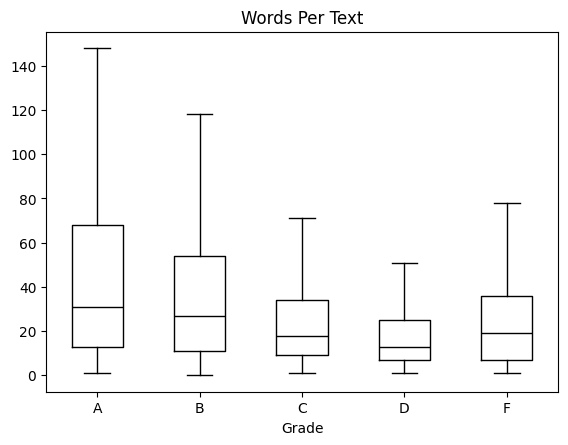

In [7]:
# INFO: 成績ごとの単語数の分布を確認

mecab = MeCab.Tagger()


def count_words(text):
    node = mecab.parseToNode(text)
    word_count = 0
    while node:
        if node.surface:
            word_count += 1
        node = node.next
    return word_count


train["Words Per Text"] = train["text"].apply(count_words)
train.boxplot(
    column="Words Per Text", by="grade", grid=False, showfliers=False, color="black"
)

plt.suptitle("")
plt.xlabel("Grade")
plt.show()

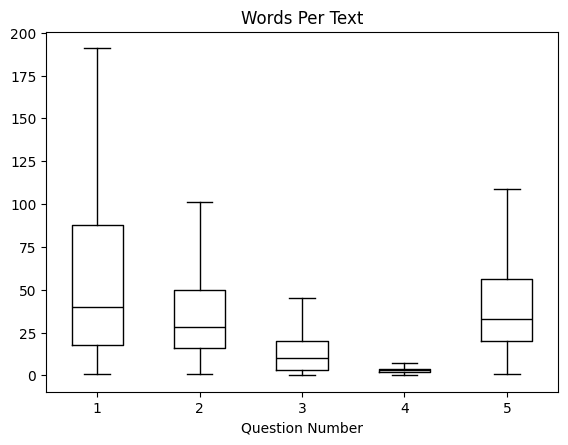

In [8]:
# INFO: 質問ごとの単語数の分布を確認
train.boxplot(
    column="Words Per Text",
    by="question_number",
    grid=False,
    showfliers=False,
    color="black",
)
plt.suptitle("")
plt.xlabel("Question Number")
plt.show()

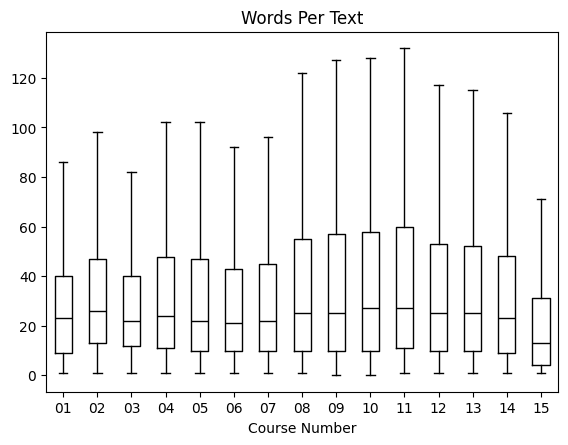

In [9]:
# INFO: 講義回数ごとの単語数の分布を確認
train.boxplot(
    column="Words Per Text",
    by="course_number",
    grid=False,
    showfliers=False,
    color="black",
)
plt.suptitle("")
plt.xlabel("Course Number")
plt.show()

## データを数値化してlightGBMに突っ込む

### 生徒のデータ形式

- `user_1`:
  - 1-1, 1-2, 1-3, 1-4, 1-5  
  - 2-1, 2-2, ..., 2-5  
  - ...  
  - 15-1, ..., 15-5

- `user_2`:
  - ...

- 各生徒の持つデータ数は膨大
- しかし全て有用であるため、とりあえず平均を使用して対応
- 質問番号は"1"のみ用いることとする

In [10]:
Input_df = pd.DataFrame()
Valid_df = pd.DataFrame()

### 1. 各文章の単語数
大事だと思うから，全て突っ込む<br>
数値の動きを擬似的な関数として定義するのもありかもしれないが，あとで考える

In [11]:
filter = "1"
temp = train.copy()
temp["text"] = train["Words Per Text"]
temp.head()

,userid,grade,text,course_number,question_number,label,Words Per Text
0,C-2022-1_U72,C,18,01,1,2,18
1,C-2021-1_U70,D,12,01,1,3,12
2,C-2021-2_U103,B,74,01,1,1,74
3,C-2021-2_U139,B,38,01,1,1,38
4,C-2022-1_U7,C,12,01,1,2,12


In [12]:
Qfilter_df = dm.encode(temp, logger=logger, filter=filter)
Input_df = pd.concat([Input_df, Qfilter_df])
Input_df = Input_df.replace("[NA]", 0)
Input_df.head()

/home/masa1357/Dockerdata/gitfile/Tree-Model/src/python/data_manager.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["new_column"] = df.apply(create_column_name, axis=1)


new_column,userid,label,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15
0,C-2021-1_U1,4,30,87,80,61,125,87,122,0,0,0,0,0,0,0,0
1,C-2021-1_U10,1,67,29,34,19,25,14,15,15,30,19,14,43,19,23,6
2,C-2021-1_U102,1,18,43,18,25,22,37,45,33,38,71,30,64,50,22,38
3,C-2021-1_U104,1,35,25,38,33,39,18,39,20,48,70,29,56,75,42,38
4,C-2021-1_U105,1,25,113,69,55,100,102,56,87,116,60,76,85,60,72,3


In [13]:
valid["Words Per Text"] = valid["text"].apply(count_words)
temp = valid.copy()
temp["text"] = valid["Words Per Text"]
Qfilter_df = dm.encode(temp, logger=logger, filter=filter)
Valid_df = pd.concat([Valid_df, Qfilter_df])
Valid_df = Valid_df.replace("[NA]", 0)
Valid_df.head()

/home/masa1357/Dockerdata/gitfile/Tree-Model/src/python/data_manager.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["new_column"] = df.apply(create_column_name, axis=1)


new_column,userid,label,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15
0,C-2021-1_U100,2,11,20,6,20,10,6,9,4,7,9,23,17,7,20,2
1,C-2021-1_U101,1,40,103,73,147,92,143,202,150,146,109,218,184,290,170,5
2,C-2021-1_U103,1,33,45,45,51,52,53,96,90,89,91,110,52,50,138,2
3,C-2021-1_U107,2,0,0,0,10,3,15,7,3,1,6,4,5,11,25,2
4,C-2021-1_U12,1,60,10,14,35,29,20,21,9,70,28,107,58,31,73,9


### 2. 各文章内の0の数

In [14]:
Input_df["zero_count"] = Input_df.isin([0]).sum(axis=1)
Valid_df["zero_count"] = Valid_df.isin([0]).sum(axis=1)
Input_df.head()

new_column,userid,label,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,zero_count
0,C-2021-1_U1,4,30,87,80,61,125,87,122,0,0,0,0,0,0,0,0,8
1,C-2021-1_U10,1,67,29,34,19,25,14,15,15,30,19,14,43,19,23,6,0
2,C-2021-1_U102,1,18,43,18,25,22,37,45,33,38,71,30,64,50,22,38,0
3,C-2021-1_U104,1,35,25,38,33,39,18,39,20,48,70,29,56,75,42,38,0
4,C-2021-1_U105,1,25,113,69,55,100,102,56,87,116,60,76,85,60,72,3,0


### 3. 各文章のベクトル間距離
多すぎるので，平均 / 中央値で保管する<br>
使うのはユークリッド距離とコサイン距離

In [15]:
args: Dict[str, object] = {
    "logger": logger,
    "MODEL_PATH": MODEL_PATH,
    "seed": seed,
}

with util.timer("Load Model..."):
    gs = mp.GetSentenceVector(args, train[train["question_number"] == filter])

[Load Model...] start


100%|██████████| 3795/3795 [00:00<00:00, 9705.12it/s] 
2024-08-15 06:34:04,214 : python.util.python.Mecab_processing : INFO : 68 : loading word2vec model ...
2024-08-15 06:34:04,238 : python.util.python.Mecab_processing : INFO : 70 : model loaded.


[Load Model...] done in 0.42 s


In [16]:
train

,userid,grade,text,course_number,question_number,label,Words Per Text
0,C-2022-1_U72,C,情報科学の時間で学習する内容や授業で使う教材システム評価方法の説明,01,1,2,18
1,C-2021-1_U70,D,授業の説明情報伝達の歴史を大まかに学んだ,01,1,3,12
2,C-2021-2_U103,B,情報教育が軽視されているが今の世の中で情報について知ることは必須である情報は伝送しやすい形に...,01,1,1,74
3,C-2021-2_U139,B,情報科学の発展は目覚ましくインタネットを使うことで様々な情報を２進数に変化し扱うことができる...,01,1,1,38
4,C-2022-1_U7,C,情報科学についてを知ることができました,01,1,2,12
...,...,...,...,...,...,...,...
22415,C-2022-1_U89,B,今日は60分間テストの後アンケトに答えて授業が終わるという日でしたので新たに知識を発見すると...,15,5,1,129
22421,C-2021-2_U46,D,情報量の計算はやりかたを覚えていなかったため解けなかった\r\n他の問題はそれなりに覚えてい...,15,5,3,37
22422,C-2021-1_U2,A,記述問題が難しかったが計算や選択問題は比較的できたと思う,15,5,0,17
22423,C-2021-1_U75,B,テストの時間が足りなかったのが残念だった情報科学の授業を通してコンピュタに関わる仕組みの基本...,15,5,1,39


In [17]:
def cosine_similarity(vec1, vec2):
    # ゼロベクトルのチェック
    if np.linalg.norm(vec1) == 0 or np.linalg.norm(vec2) == 0:
        return 0.0

    # SciPyのコサイン距離を使用してコサイン類似度を計算
    return 1 - distance.cosine(vec1, vec2)

In [18]:
def get_vector_distance(df, filter=1):
    logger.info(f"Start get_vector_distance")
    Enc_df = dm.encode(df=df, logger=logger, filter=filter)
    data_X = {}
    data_Y = {}
    texts = {}

    for j in range(1, 16):
        column_name = f"{j:02d}"
        columns = ["userid", column_name, "label"]
        with util.timer(f"GetSentenceVector:{column_name}"):
            data_X[j], data_Y[j], texts[j] = gs(df=Enc_df[columns], key=column_name)

    logger.info(f"get Euclidean Distance")
    distances_df = pd.DataFrame()
    with util.timer(f"Calculate Euclidean Distance:"):
        # 全ての行に対して繰り返す
        for j in range(len(data_X[1])):
            for i in range(1, 15):
                name = f"euc_{i}:{i+1}"
                vec1 = data_X[i].iloc[j].values
                vec2 = data_X[i + 1].iloc[j].values
                distances_df.loc[j, name] = np.linalg.norm(vec1 - vec2)
            # 全ての列の平均値を計算
            distances_df.loc[j, "euc_mean"] = distances_df.loc[j].mean()
    
    logger.info(f"get Cosine Distance")
    cosdist_df = pd.DataFrame()
    with util.timer(f"Calculate cosine Distance:"):
        for j in range(len(data_X[1])):
            for i in range(1, 15):
                name = f"cos_{i}:{i+1}"
                vec1 = data_X[i].iloc[j].values
                vec2 = data_X[i + 1].iloc[j].values
                cosdist_df.loc[j, name] = 1 - cosine_similarity(vec1, vec2)
            # 全ての列の平均値を計算
            cosdist_df.loc[j, "cos_mean"] = cosdist_df.loc[j].mean()
    # cosdist_df["Category"] = data_Y[1]["category_id"]

    # df['Euclidean Distance'] = distances_df["mean"]
    # df['Cosine Distance'] = cosdist_df["mean"]
    
    return distances_df, cosdist_df

In [19]:
te_dist, tc_dist = get_vector_distance(train, filter=filter)
ve_dist, vc_dist = get_vector_distance(valid, filter=filter)

2024-08-15 06:34:04,299 : python.util : INFO : 2 : Start get_vector_distance


/home/masa1357/Dockerdata/gitfile/Tree-Model/src/python/data_manager.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["new_column"] = df.apply(create_column_name, axis=1)


[GetSentenceVector:01] start


299it [00:00, 6220.23it/s]


[GetSentenceVector:01] done in 0.06 s
[GetSentenceVector:02] start


299it [00:00, 4863.93it/s]


[GetSentenceVector:02] done in 0.08 s
[GetSentenceVector:03] start


299it [00:00, 6038.02it/s]


[GetSentenceVector:03] done in 0.07 s
[GetSentenceVector:04] start


299it [00:00, 4971.39it/s]


[GetSentenceVector:04] done in 0.07 s
[GetSentenceVector:05] start


299it [00:00, 4670.98it/s]


[GetSentenceVector:05] done in 0.08 s
[GetSentenceVector:06] start


299it [00:00, 4677.69it/s]


[GetSentenceVector:06] done in 0.08 s
[GetSentenceVector:07] start


299it [00:00, 4667.74it/s]


[GetSentenceVector:07] done in 0.08 s
[GetSentenceVector:08] start


299it [00:00, 4313.35it/s]


[GetSentenceVector:08] done in 0.08 s
[GetSentenceVector:09] start


299it [00:00, 3712.69it/s]


[GetSentenceVector:09] done in 0.10 s
[GetSentenceVector:10] start


299it [00:00, 3874.10it/s]


[GetSentenceVector:10] done in 0.09 s
[GetSentenceVector:11] start


299it [00:00, 3316.55it/s]


[GetSentenceVector:11] done in 0.11 s
[GetSentenceVector:12] start


299it [00:00, 4146.67it/s]


[GetSentenceVector:12] done in 0.09 s
[GetSentenceVector:13] start


299it [00:00, 4072.02it/s]


[GetSentenceVector:13] done in 0.09 s
[GetSentenceVector:14] start


299it [00:00, 3956.94it/s]


[GetSentenceVector:14] done in 0.09 s
[GetSentenceVector:15] start


299it [00:00, 23880.74it/s]
2024-08-15 06:34:05,577 : python.util : INFO : 14 : get Euclidean Distance


[GetSentenceVector:15] done in 0.03 s
[Calculate Euclidean Distance:] start


2024-08-15 06:34:06,440 : python.util : INFO : 27 : get Cosine Distance


[Calculate Euclidean Distance:] done in 0.86 s
[Calculate cosine Distance:] start


2024-08-15 06:34:07,392 : python.util : INFO : 2 : Start get_vector_distance
/home/masa1357/Dockerdata/gitfile/Tree-Model/src/python/data_manager.py:285: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["new_column"] = df.apply(create_column_name, axis=1)


[Calculate cosine Distance:] done in 0.95 s
[GetSentenceVector:01] start


75it [00:00, 5684.06it/s]


[GetSentenceVector:01] done in 0.02 s
[GetSentenceVector:02] start


75it [00:00, 3906.57it/s]


[GetSentenceVector:02] done in 0.03 s
[GetSentenceVector:03] start


75it [00:00, 3991.84it/s]


[GetSentenceVector:03] done in 0.03 s
[GetSentenceVector:04] start


75it [00:00, 3634.28it/s]


[GetSentenceVector:04] done in 0.03 s
[GetSentenceVector:05] start


75it [00:00, 3726.86it/s]


[GetSentenceVector:05] done in 0.03 s
[GetSentenceVector:06] start


75it [00:00, 3592.33it/s]


[GetSentenceVector:06] done in 0.03 s
[GetSentenceVector:07] start


75it [00:00, 3411.93it/s]


[GetSentenceVector:07] done in 0.03 s
[GetSentenceVector:08] start


75it [00:00, 3445.90it/s]


[GetSentenceVector:08] done in 0.03 s
[GetSentenceVector:09] start


75it [00:00, 2256.26it/s]


[GetSentenceVector:09] done in 0.04 s
[GetSentenceVector:10] start


75it [00:00, 3136.44it/s]


[GetSentenceVector:10] done in 0.03 s
[GetSentenceVector:11] start


75it [00:00, 2804.55it/s]


[GetSentenceVector:11] done in 0.03 s
[GetSentenceVector:12] start


75it [00:00, 3590.40it/s]


[GetSentenceVector:12] done in 0.03 s
[GetSentenceVector:13] start


75it [00:00, 3072.03it/s]


[GetSentenceVector:13] done in 0.03 s
[GetSentenceVector:14] start


75it [00:00, 3422.51it/s]


[GetSentenceVector:14] done in 0.03 s
[GetSentenceVector:15] start


75it [00:00, 21398.05it/s]
2024-08-15 06:34:07,876 : python.util : INFO : 14 : get Euclidean Distance
2024-08-15 06:34:08,100 : python.util : INFO : 27 : get Cosine Distance


[GetSentenceVector:15] done in 0.01 s
[Calculate Euclidean Distance:] start
[Calculate Euclidean Distance:] done in 0.22 s
[Calculate cosine Distance:] start
[Calculate cosine Distance:] done in 0.24 s


In [20]:
Input_df = pd.concat([Input_df, te_dist, tc_dist], axis=1)
Valid_df = pd.concat([Valid_df, ve_dist, vc_dist], axis=1)

In [21]:
Input_df

,userid,label,01,02,03,04,05,06,07,08,...,cos_6:7,cos_7:8,cos_8:9,cos_9:10,cos_10:11,cos_11:12,cos_12:13,cos_13:14,cos_14:15,cos_mean
0,C-2021-1_U1,4,30,87,80,61,125,87,122,0,...,0.162113,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.707963
1,C-2021-1_U10,1,67,29,34,19,25,14,15,15,...,0.243161,0.609887,0.515429,0.433334,0.393881,0.387232,0.393316,0.410598,0.727928,0.419847
2,C-2021-1_U102,1,18,43,18,25,22,37,45,33,...,0.181309,0.214902,0.303140,0.237677,0.299865,0.338421,0.154982,0.296944,0.292031,0.262619
3,C-2021-1_U104,1,35,25,38,33,39,18,39,20,...,0.273386,0.365410,0.239215,0.177487,0.261569,0.398801,0.296292,0.282055,0.342060,0.297801
4,C-2021-1_U105,1,25,113,69,55,100,102,56,87,...,0.164302,0.410393,0.278022,0.300838,0.370572,0.327690,0.269427,0.232159,0.693954,0.328433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,C-2022-1_U92,3,9,18,30,30,30,8,34,13,...,0.322626,0.422590,0.501284,0.251137,0.575468,0.499524,0.228513,0.244740,1.000000,0.392229
295,C-2022-1_U93,2,17,23,22,14,8,12,45,26,...,0.380005,0.304963,0.290213,0.356644,0.298846,0.291675,0.301791,1.000000,1.000000,0.438704
296,C-2022-1_U94,2,34,39,48,32,37,29,29,25,...,0.269375,0.400174,0.483298,0.510913,0.556429,0.501004,0.395705,0.479066,0.692518,0.451292
297,C-2022-1_U95,2,11,6,0,0,0,0,0,6,...,1.000000,1.000000,0.181500,1.000000,1.000000,1.000000,1.000000,0.469333,1.000000,0.846040


<Axes: title={'center': 'cos_mean'}, xlabel='label'>

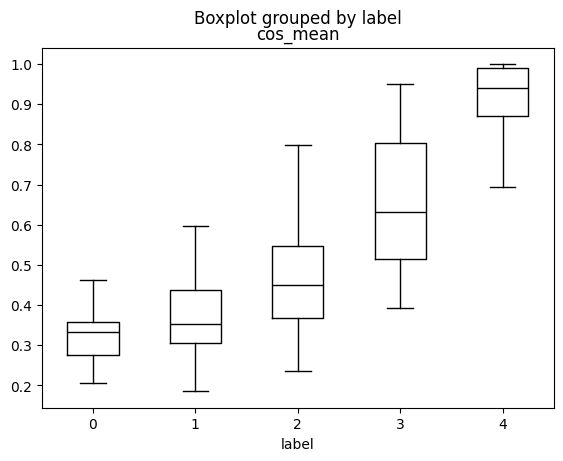

In [22]:
Input_df.boxplot(column='cos_mean', by='label', grid=False, showfliers=False, color='black')

<Axes: title={'center': 'cos_mean'}, xlabel='label'>

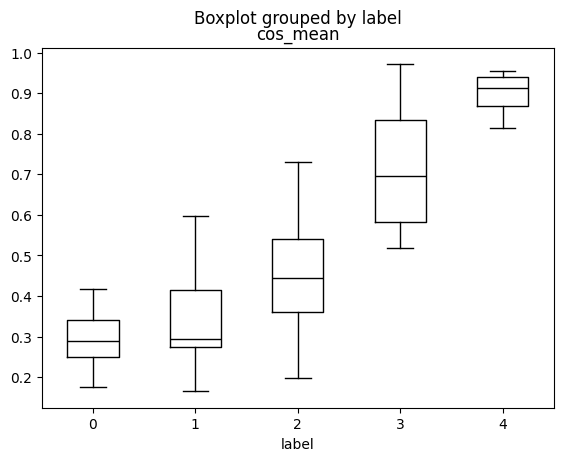

In [23]:
# INFO: このとき，Validを用いて分散表現を訓練していないことに留意すること．
Valid_df.boxplot(column='cos_mean', by='label', grid=False, showfliers=False, color='black')

### LightGBM Model の訓練

In [24]:
X_train = Input_df.drop(["label", "userid"], axis=1)
X_valid = Valid_df.drop(["label", "userid"], axis=1)
y_train = Input_df["label"]
y_valid = Valid_df["label"]

In [25]:
X_train = X_train.astype(float)
X_valid = X_valid.astype(float)
y_train = y_train.astype(float)
y_valid = y_valid.astype(float)

In [26]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

In [27]:
params = {
    'objective': 'multiclass',
    'num_class': 5,
    'metric': 'multi_logloss',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'num_iterations': 1000,
    'max_depth': 12,
    'learning_rate': 0.01,
    'num_leaves': 31
}


# wandb.config.update(params)

In [28]:
# def Tree_kfold(X_train, y_train, X_valid, y_valid, params, table=None):
#     oof = np.zeros((X_train.shape[0], 5))
#     prediction = np.zeros((X_valid.shape[0], 5))

#     accuracies = []
#     f1_scores = []

#     kf = KFold(n_splits=5, shuffle=True, random_state=42)
#     for fold, (train_idx, valid_idx) in enumerate(kf.split(X_train)):
#         logger.info(f"Fold {fold + 1}")
#         X_trn = X_train[train_idx]
#         X_val = X_train[valid_idx]
#         y_trn = y_train[train_idx]
#         y_val = y_train[valid_idx]

#         lgb_train = lgb.Dataset(X_trn, y_trn)
#         lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

#         # paramsが辞書形式か確認
#         logger.info(params)
#         logger.info("Train LightGBM Model")
#         model = lgb.train(
#             params,
#             lgb_train,
#             valid_sets=[lgb_train, lgb_eval],
#             valid_names=["train", "valid"],
#             callbacks=[wandb_callback(), lgb.early_stopping(stopping_rounds=100)],
#         )
#         logger.info("Predict Validation Data")
#         oof[valid_idx] = model.predict(X_val, num_iteration=model.best_iteration)
#         # prediction += (
#         #     model.predict(X_valid, num_iteration=model.best_iteration) / kf.n_splits
#         # )

#         accuracy = accuracy_score(y_val, np.argmax(oof[valid_idx], axis=1))
#         logger.info(f"Fold {fold + 1} Accuracy: {accuracy}")
#         f1 = f1_score(y_val, np.argmax(oof[valid_idx], axis=1), average="macro")
#         logger.info(f"Fold {fold + 1} F1 Score: {f1}")
#         accuracies.append(accuracy)
#         f1_scores.append(f1)
        
#         # log wandb
#         if table is not None:
#             table.add_data(
#                 params.get("objective"),
#                 params.get("num_class"),
#                 params.get("metric"),
#                 params.get("boosting_type"),
#                 params.get("num_iterations"),
#                 params.get("max_depth"),
#                 params.get("learning_rate"),
#                 params.get("num_leaves"),
#                 params.get("verbosity"),
#                 fold + 1,
#                 accuracy,
#                 f1,
#             )
#             wandb.log({"Fold metrics": table})
#         else:
#             pass
#             wandb.log({"Fold": fold + 1, "Accuracy": accuracy, "F1 Score": f1})

#     final_accuracy = np.mean(accuracies)
#     final_f1 = np.mean(f1_scores)
#     logger.info(f"Final Accuracy: {final_accuracy}")
#     logger.info(f"Final F1 Score: {final_f1}")

#     # predict validation data
#     lgb_train = lgb.Dataset(X_train, y_train)
#     lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
#     logger.info("Predict Validation Data")
#     valmodel = lgb.train(
#         params,
#         lgb_train,
#         valid_sets=[lgb_train, lgb_eval],
#         valid_names=["train", "valid"],
#         callbacks=[wandb_callback(), lgb.early_stopping(stopping_rounds=100)],
#     )
#     prediction = valmodel.predict(X_valid, num_iteration=model.best_iteration)
#     valid_accuracy = accuracy_score(y_valid, np.argmax(prediction, axis=1))
#     valid_f1 = f1_score(y_valid, np.argmax(prediction, axis=1), average="macro")
#     logger.info(f"Validation Accuracy: {valid_accuracy}")
#     logger.info(f"Validation F1 Score: {valid_f1}")

#     wandb.log({"Final Accuracy": final_accuracy, "Final F1 Score": final_f1})
#     wandb.log({"Validation Accuracy": valid_accuracy, "Validation F1 Score": valid_f1})

In [29]:
def train_treemodel(X_train, y_train, X_valid, y_valid, params, table=None):
    # train LightGBM model
    print(params)
    print("make dataset")
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    logger.info("Train LightGBM Model")
    print("train model")
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        valid_names=["train", "valid"],
        callbacks=[lgb.early_stopping(stopping_rounds=100)],
    )
    print("predict")
    # predict validation data
    logger.info("Predict Validation Data")
    prediction = model.predict(X_valid, num_iteration=model.best_iteration)
    # calculate metrics
    accuracy = accuracy_score(y_valid, np.argmax(prediction, axis=1))
    f1 = f1_score(y_valid, np.argmax(prediction, axis=1), average="macro")

    logger.info(f"Accuracy: {accuracy}")
    logger.info(f"F1 Score: {f1}")

    # wandb.log({"Accuracy": accuracy, "F1 Score": f1})
    #confusion matrixをwandbに保存
    # wandb.sklearn.plot_confusion_matrix(y_valid, np.argmax(prediction, axis=1))

    cf = confusion_matrix(y_valid, np.argmax(prediction, axis=1))
    sns.heatmap(cf, annot=True, cmap='Blues')
    plt.show()
    

    return model

2024-08-15 06:34:08,856 : python.util : INFO : 7 : Train LightGBM Model


{'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'num_iterations': 1000, 'max_depth': 12, 'learning_rate': 0.01, 'num_leaves': 31}
make dataset
train model


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds


2024-08-15 06:34:10,561 : python.util : INFO : 18 : Predict Validation Data
2024-08-15 06:34:10,566 : python.util : INFO : 24 : Accuracy: 0.6133333333333333
2024-08-15 06:34:10,566 : python.util : INFO : 25 : F1 Score: 0.482072673340749


Early stopping, best iteration is:
[119]	train's multi_logloss: 0.522916	valid's multi_logloss: 0.965101
predict


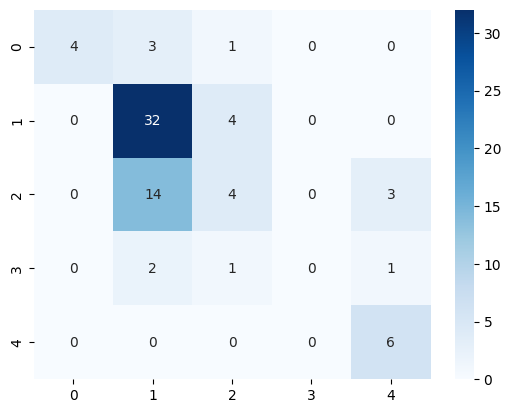

In [30]:
model = train_treemodel(
    X_train.values, y_train.values, X_valid.values, y_valid.values, params
)

### 分析

#### 重要度

In [31]:
Valid_df.head()

,userid,label,01,02,03,04,05,06,07,08,...,cos_6:7,cos_7:8,cos_8:9,cos_9:10,cos_10:11,cos_11:12,cos_12:13,cos_13:14,cos_14:15,cos_mean
0,C-2021-1_U100,2,11,20,6,20,10,6,9,4,...,0.335186,0.443204,0.269541,0.524499,0.402531,0.293100,0.254537,0.278125,0.753453,0.400330
1,C-2021-1_U101,1,40,103,73,147,92,143,202,150,...,0.174013,0.275894,0.234415,0.245370,0.280505,0.238551,0.187702,0.156384,0.634552,0.274324
2,C-2021-1_U103,1,33,45,45,51,52,53,96,90,...,0.165221,0.332997,0.277540,0.153421,0.270732,0.340060,0.272196,0.281385,0.740730,0.289311
3,C-2021-1_U107,2,0,0,0,10,3,15,7,3,...,0.467207,0.679272,1.000000,1.000000,0.505511,0.619588,0.504245,0.424513,0.724140,0.730680
4,C-2021-1_U12,1,60,10,14,35,29,20,21,9,...,0.204962,0.462957,0.229138,0.240811,0.310763,0.188457,0.184174,0.203084,0.252868,0.277379


分析結果：
- 最も根拠になってるのはコサイン距離の平均値
- 最初の回答の単語数，14-15回間のコサイン距離が続く

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

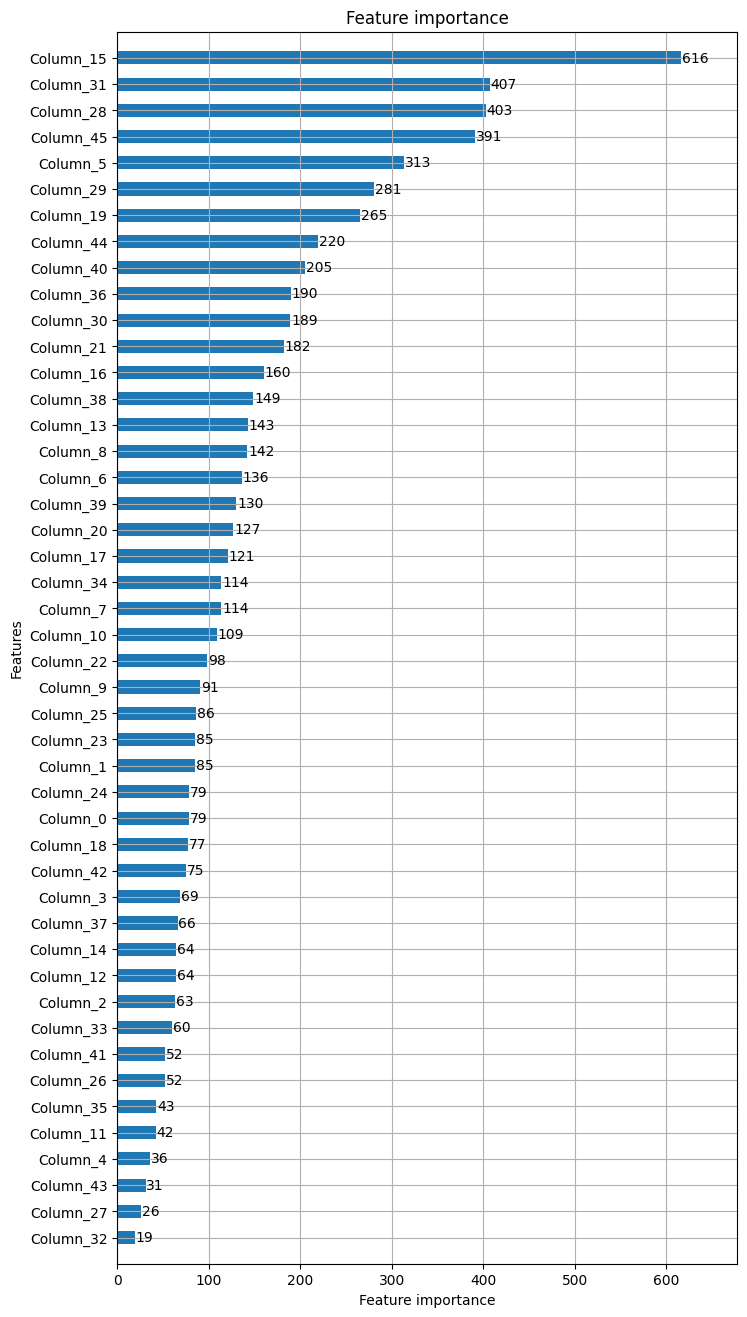

In [32]:
# 性能向上に寄与する度合いで重要度をプロット
lgb.plot_importance(model, height = 0.5, figsize = (8,16))

#### SHAP重要度

In [33]:
import shap

#notebook内でJavascriptを動かすためのおまじない
shap.initjs()

"""
shap.TreeExplainer:決定木用(XGBoost、lightBGM等含む)
shap.LinearExplainer :線形モデル用
shap.DeepExplainer :Deeplearning用
"""
#TreeExplainerは、決定木系のモデルのSHAP値を取得するもの。
explainer = shap.Explainer(model=model)

print(explainer.expected_value)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[-11.10500393]


In [34]:
"""
modelと解釈したいデータを渡す　
※なお、indexのresetは別に不要ですがtestデータのindexが何番かをいちいち確認するのが面倒なのでresetしてます。
"""
X_valid = Valid_df.drop(["label", "userid"], axis=1).astype(float)
X_test_shap = X_valid.copy().reset_index(drop=True)
shap_values = explainer(X=X_test_shap)

#n番目
n = 0 
# n番目テストデータの予測値
pred = np.argmax(model.predict(X_valid.values)[n])
print('予測値：', pred)
#n番目テストデータの真値
print('真値：', y_valid.values[n])

#n番目テストデータのSHAP値
print('shap値：', shap_values[n].values)            
  
         

予測値： 2
真値： 2.0
shap値： [[ 3.21744500e-03 -8.07341072e-02 -2.04449376e-02 -5.41157153e-03
   2.29457383e-05]
 [-1.34899958e-05  1.92343117e-03 -1.06626175e-02 -5.00539760e-02
  -1.32520598e-03]
 [ 2.42937440e-07  4.65900228e-03  5.67331447e-02  2.55637335e-02
   0.00000000e+00]
 [ 5.97668520e-04 -4.66175801e-03 -3.45024540e-03  6.02808123e-02
   8.94980850e-07]
 [ 5.35993860e-05 -6.92857401e-04  1.55777489e-02  1.63813455e-03
   0.00000000e+00]
 [-1.51967139e-05 -3.53914585e-01  2.51520225e-02  7.63623131e-02
  -4.05984490e-03]
 [-8.58533017e-02  2.31259300e-03  3.76500497e-02 -6.52217676e-02
   0.00000000e+00]
 [-5.16601253e-04 -2.68570398e-01  0.00000000e+00  1.31887006e-02
  -2.99584982e-04]
 [-2.15291420e-01  2.51840986e-03  5.49681716e-02 -9.86646980e-05
  -6.17332480e-08]
 [ 0.00000000e+00  0.00000000e+00  7.48419950e-02  2.38310142e-01
   0.00000000e+00]
 [ 2.81923216e-03  1.50498485e-02  4.41342819e-02 -1.87216123e-01
   2.65475077e-06]
 [ 3.06450520e-05 -8.10800220e-04  2.296799

In [35]:
#n番目テストデータの基礎スコア
print('基礎スコア：', shap_values[n].base_values) 

基礎スコア： [-2.60055642 -0.76916613 -1.38582113 -3.30603154 -3.04342871]


In [36]:
#n番目テストデータの説明変数数値
print('説明変数値：', shap_values[n].data) 

説明変数値： [11.         20.          6.         20.         10.          6.
  9.          4.          7.          9.         23.         17.
  7.         20.          2.          0.          1.34038615  1.22783566
  1.77455544  1.75610232  1.24462318  1.45187998  1.62567055  1.1043185
  1.6821059   1.37126684  0.99441981  0.97348303  1.0386498   5.27707338
  1.63302648  0.39184651  0.28500432  0.48916994  0.53660458  0.34782147
  0.33518632  0.44320429  0.26954073  0.52449931  0.40253097  0.29309991
  0.25453677  0.27812528  0.75345348  0.40033028]


In [37]:
shap_values.base_values[0]

array([-2.60055642, -0.76916613, -1.38582113, -3.30603154, -3.04342871])

In [38]:
print(shap_values.shape)
print(X_test_shap.shape)

(75, 46, 5)
(75, 46)


Class 0 SHAP Summary Plot


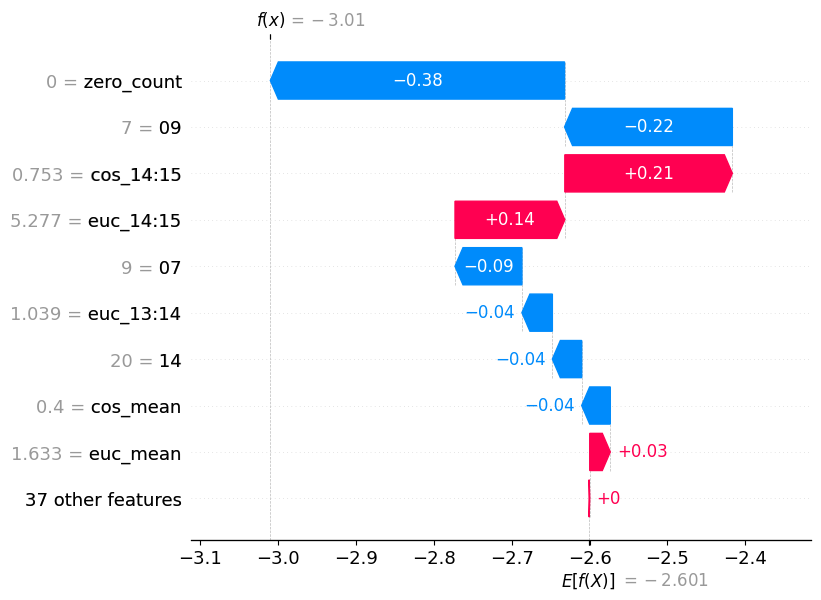

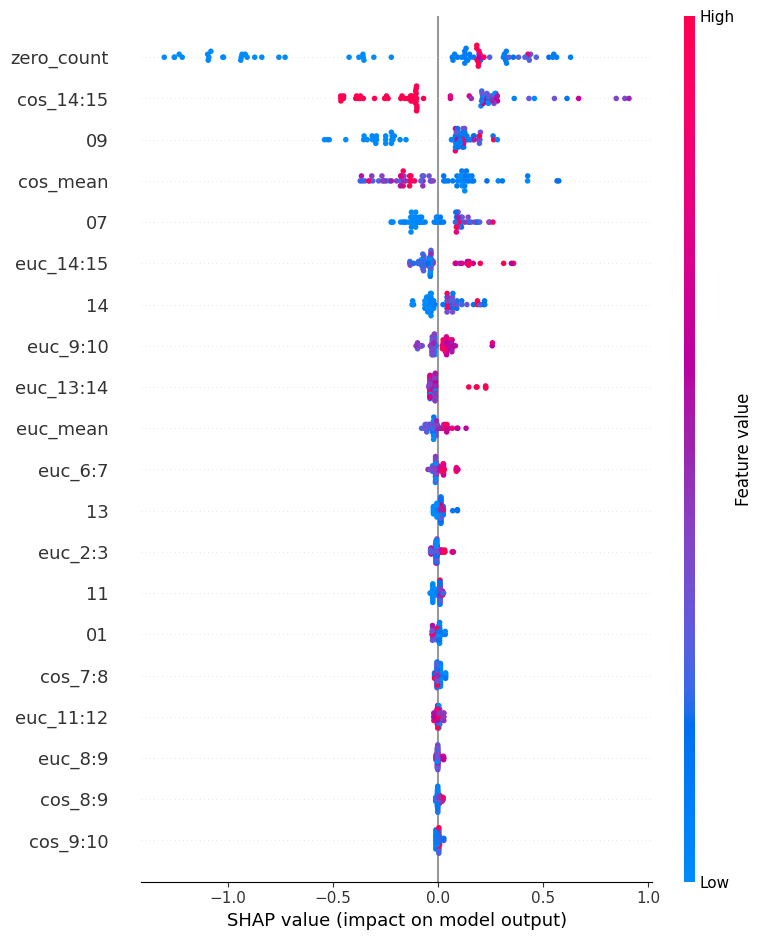

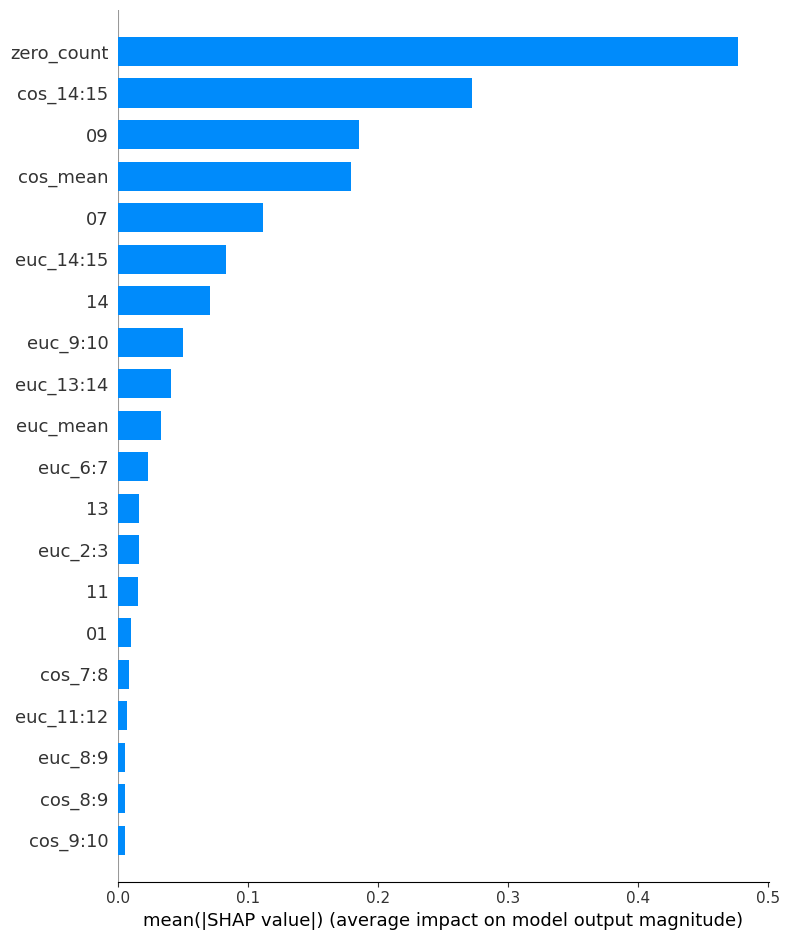

Class 1 SHAP Summary Plot


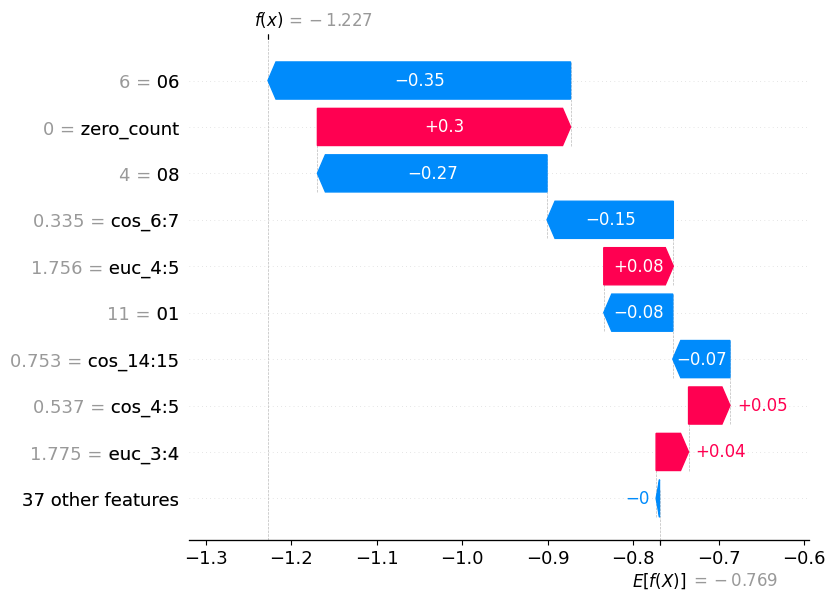

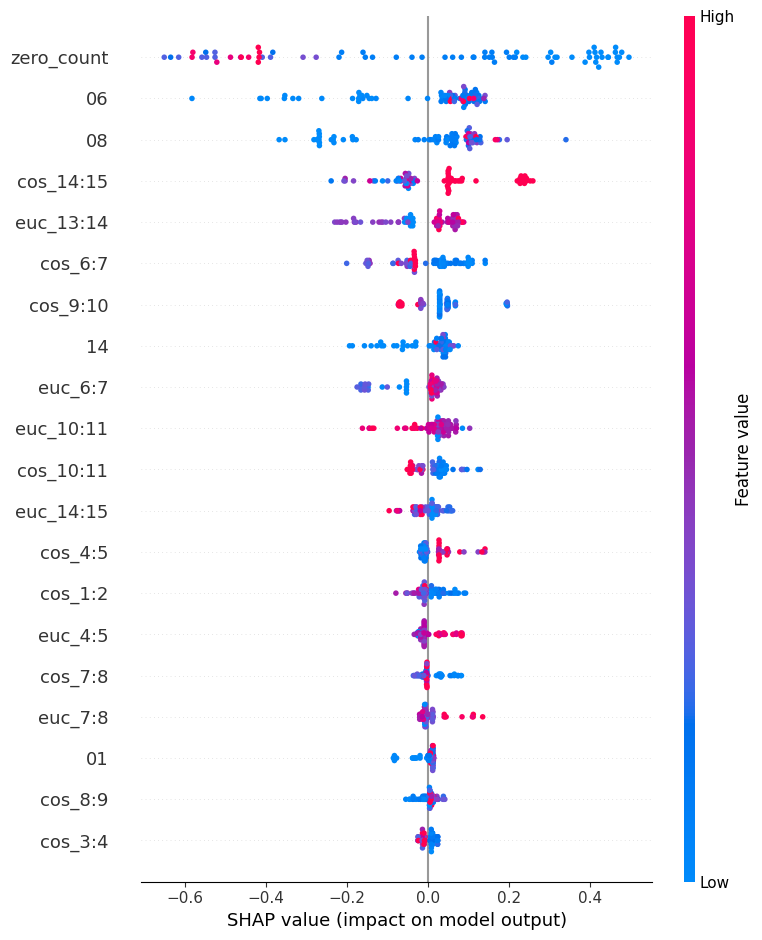

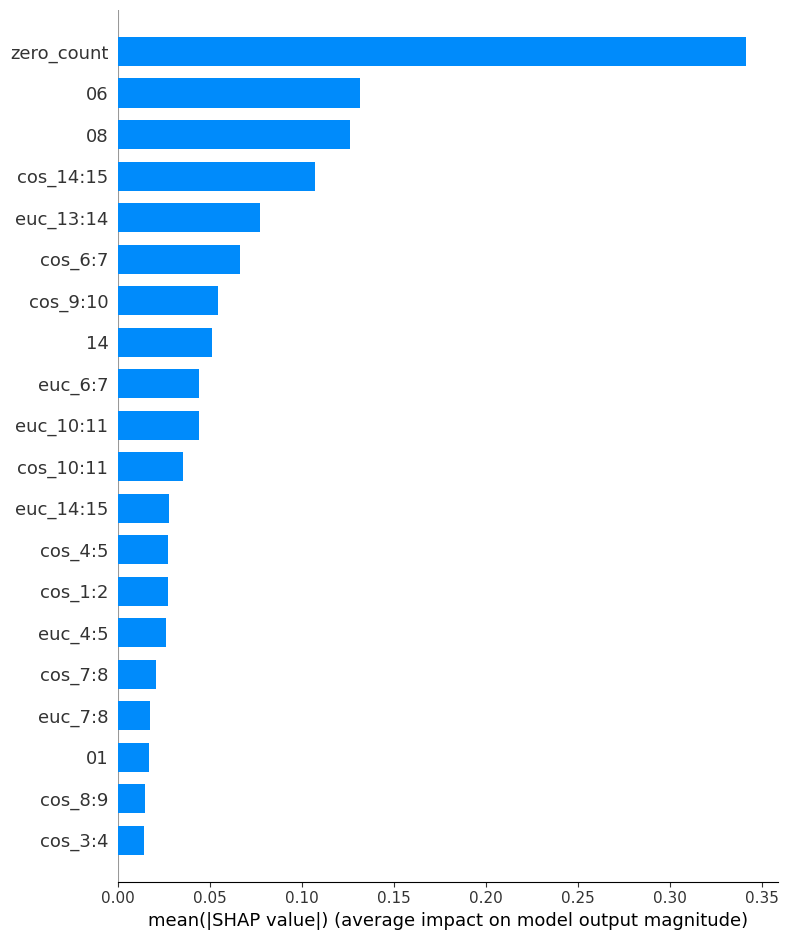

Class 2 SHAP Summary Plot


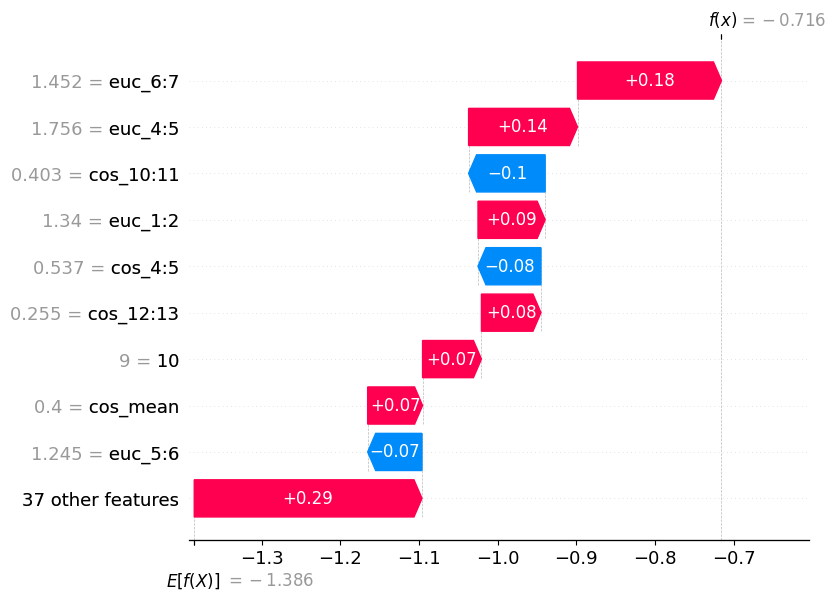

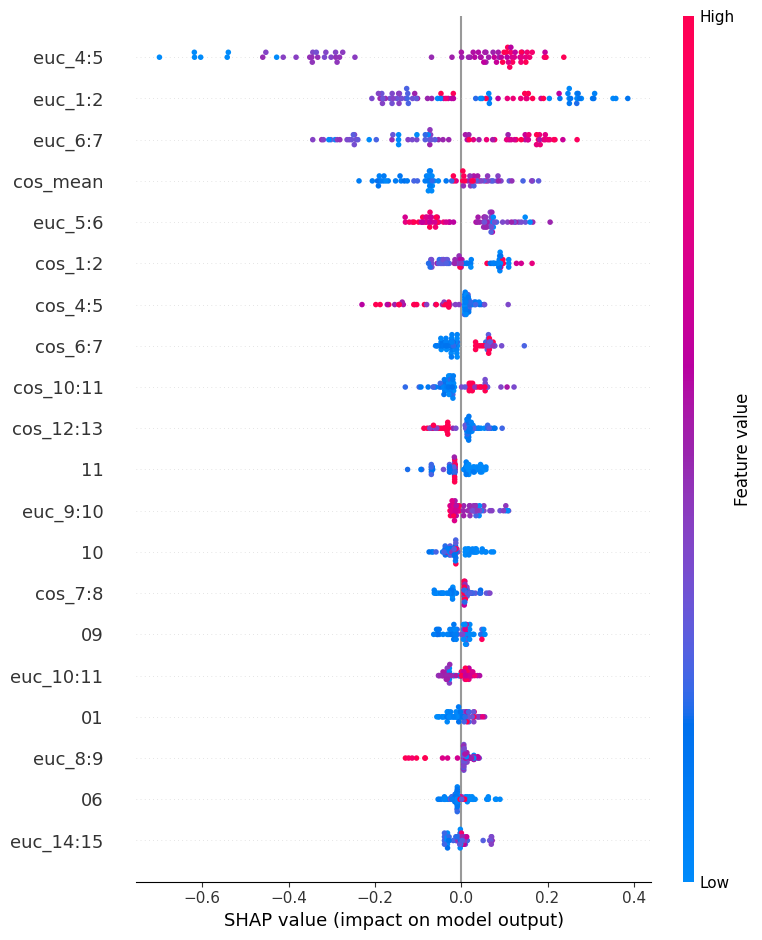

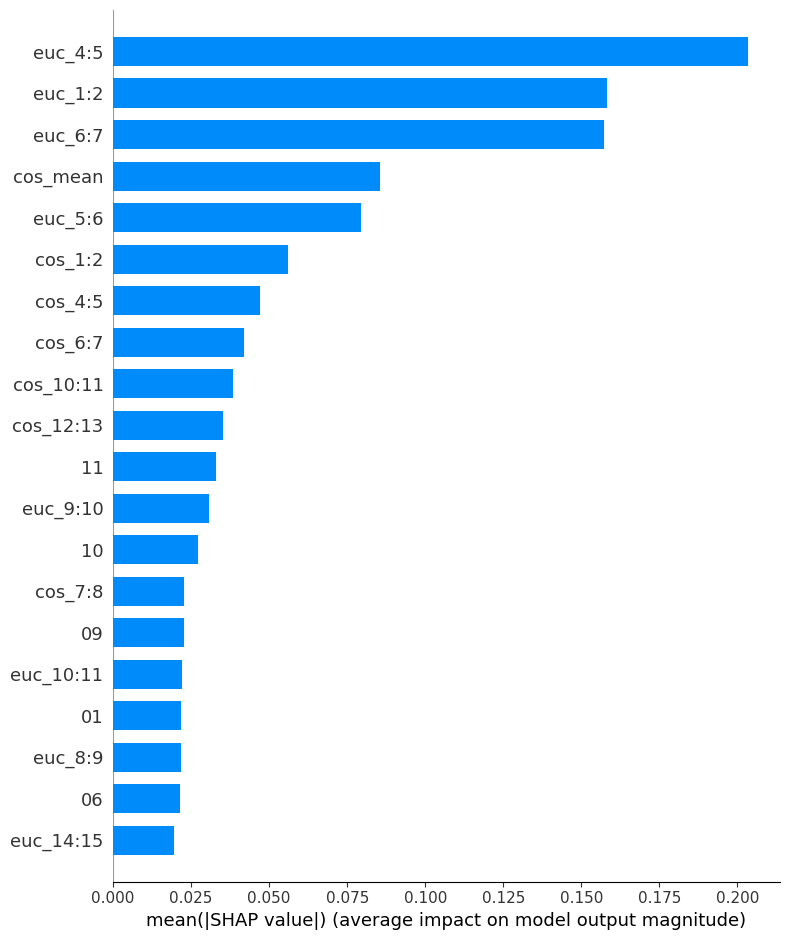

Class 3 SHAP Summary Plot


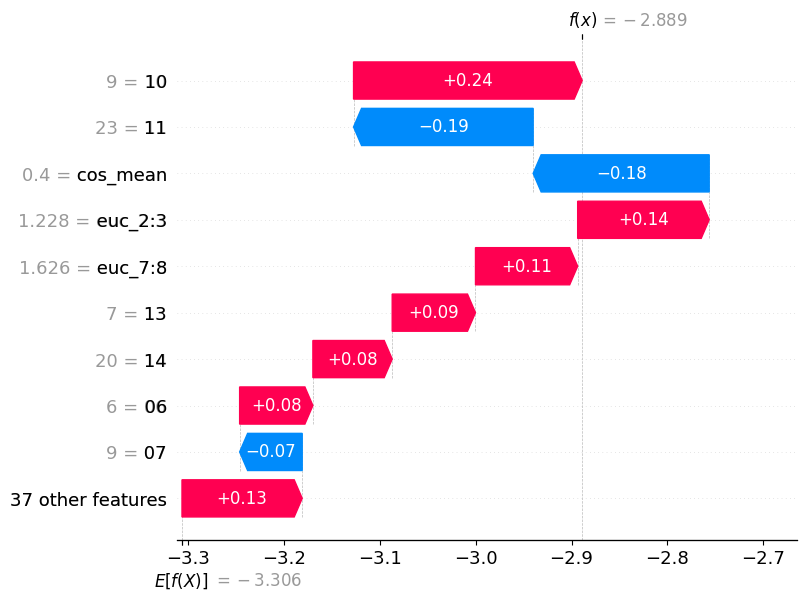

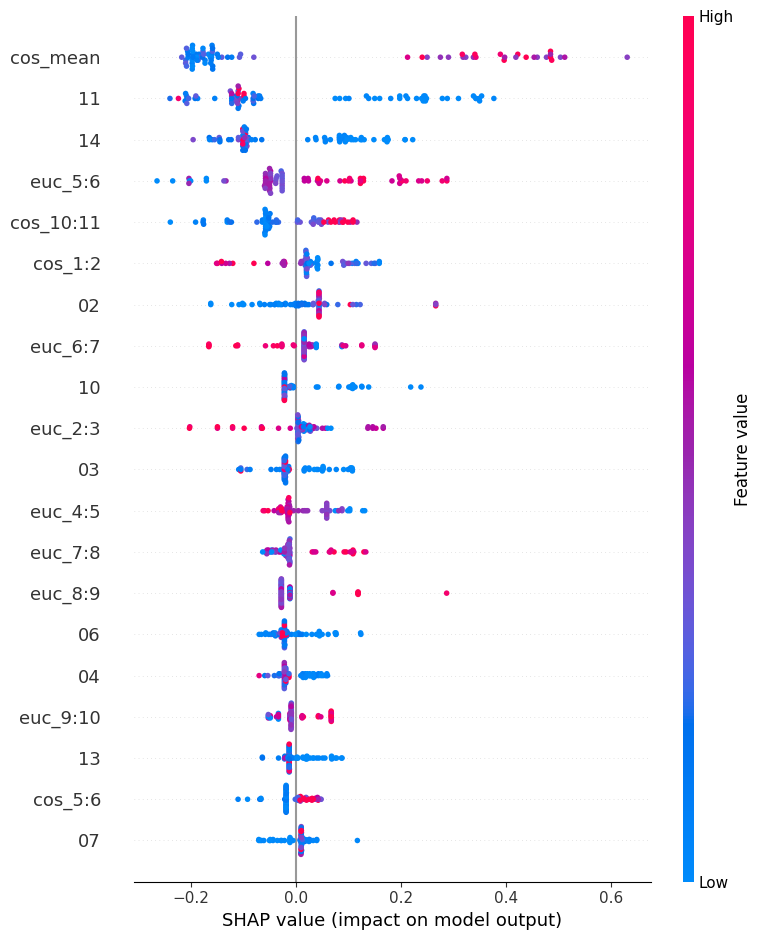

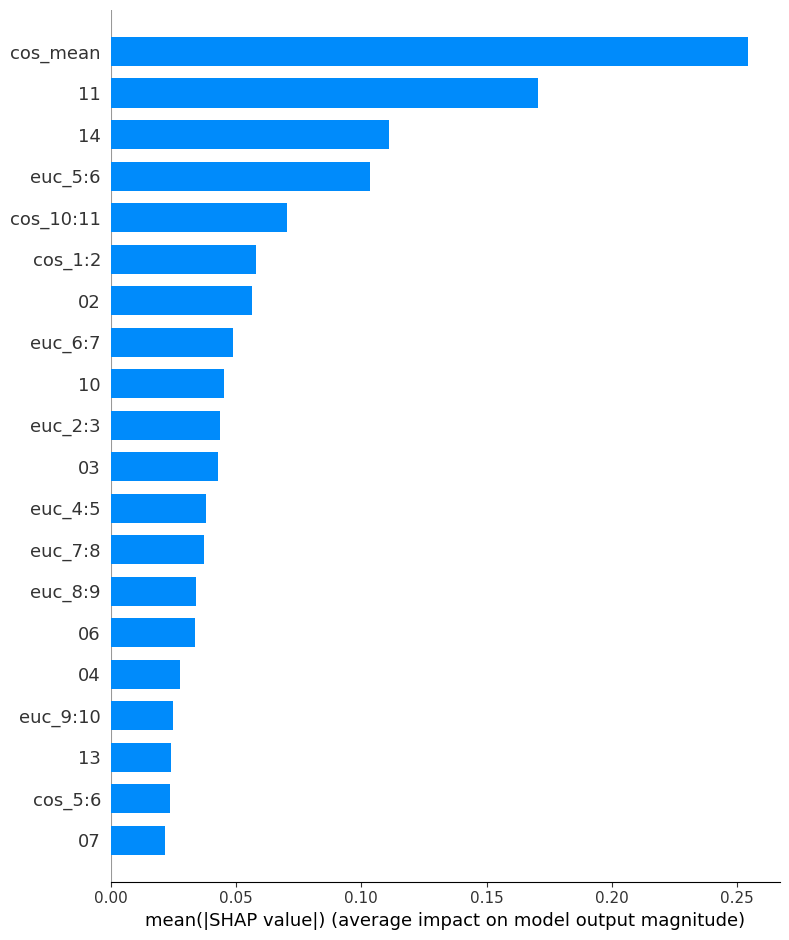

Class 4 SHAP Summary Plot


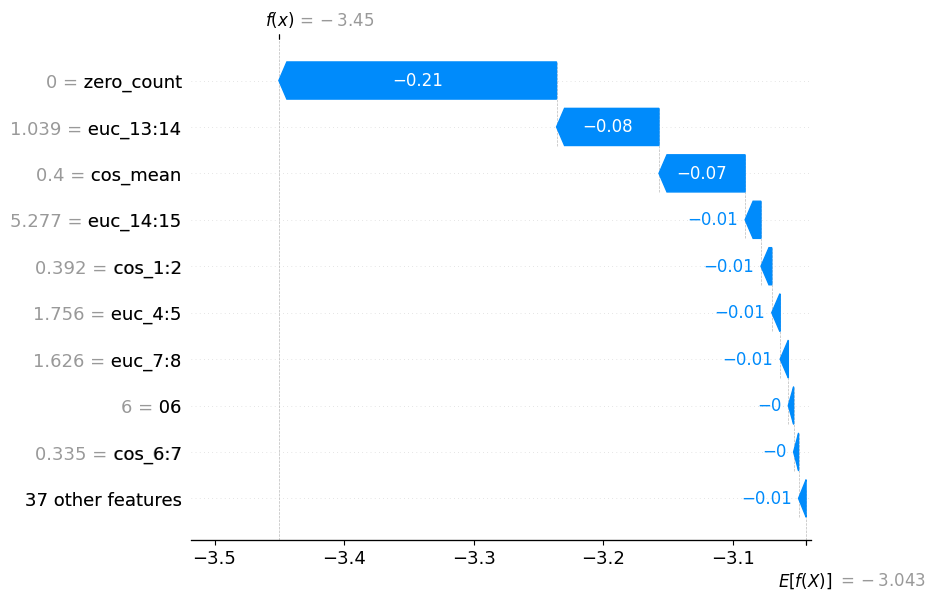

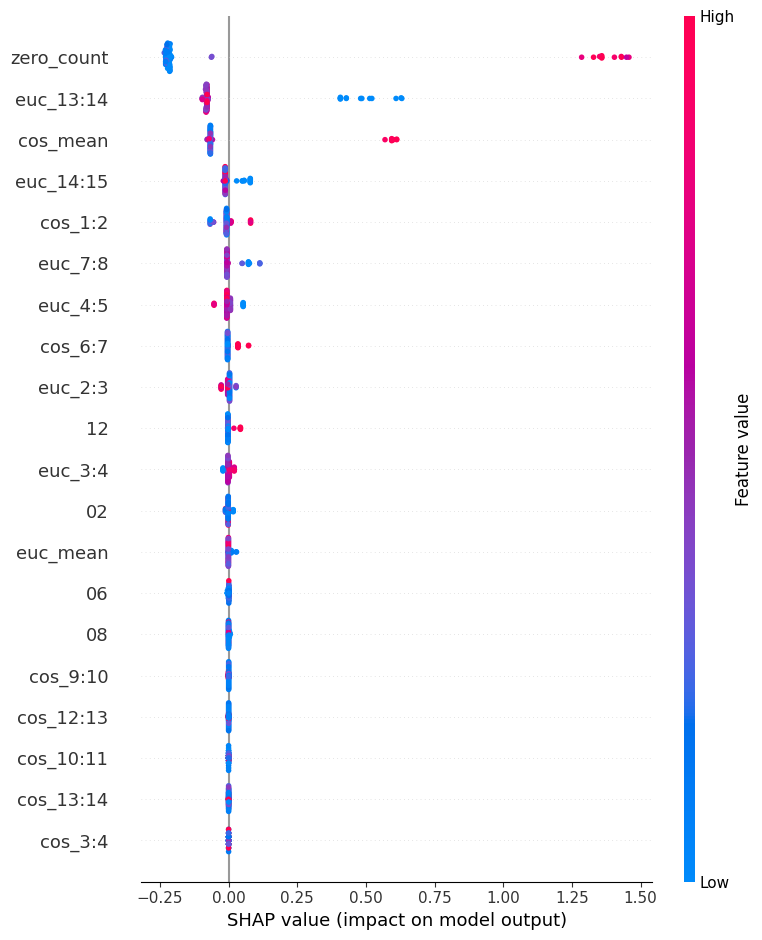

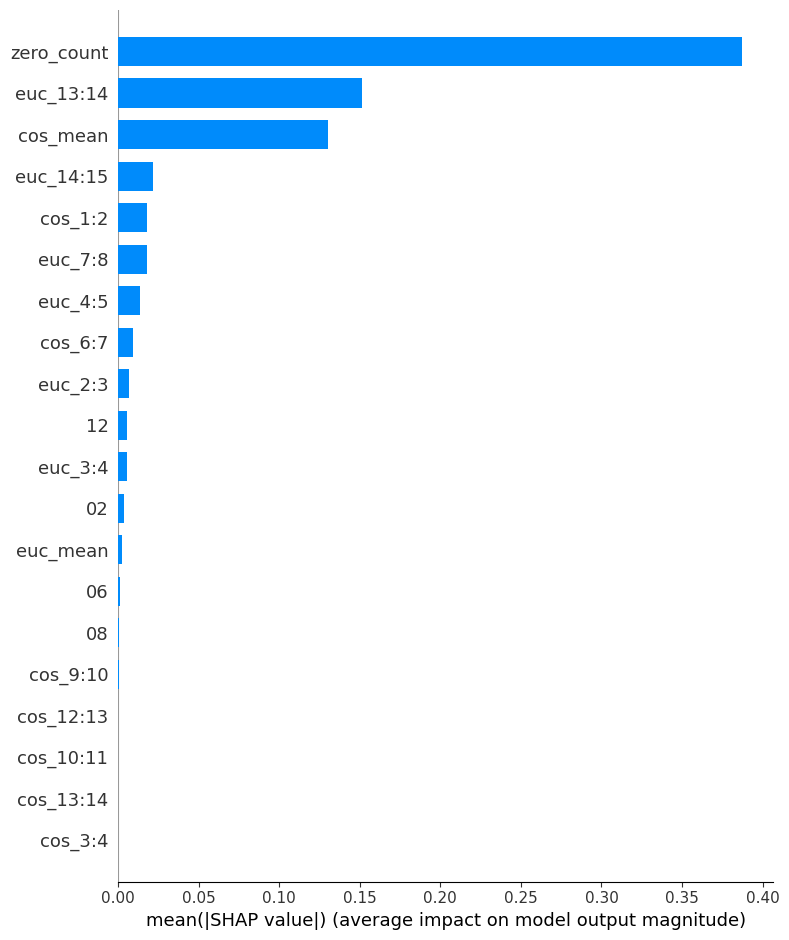

In [39]:
for class_idx in range(5):
    print(f"Class {class_idx} SHAP Summary Plot")
    # 特定のサンプル n に対してウォーターフォールプロットを作成
    shap.waterfall_plot(shap.Explanation(
        values=shap_values[n, :, class_idx],
        base_values=explainer.expected_value[class_idx],
        data=X_test_shap.iloc[n, :],
        feature_names=X_test_shap.columns
    ))
    shap.summary_plot(shap_values[:,  :, class_idx], X_test_shap)
    shap.summary_plot(shap_values[:, :, class_idx], X_test_shap, plot_type="bar")
    


In [41]:
# 各クラスに対するSHAP Force Plotの描画
for class_idx in range(5):
    print(f"Class {class_idx} SHAP Force Plot")
    
    # n番目のサンプルに対するSHAP値のフォースプロットを表示
    shap_values_for_force_plot = shap.Explanation(
        values=shap_values[n, :, class_idx],
        base_values=explainer.expected_value[class_idx],
        data=X_test_shap.iloc[n, :],
        feature_names=X_test_shap.columns
    )
    
    # フォースプロットを表示
    force_plot =  shap.force_plot(
        base_value=shap_values_for_force_plot.base_values,
        shap_values=shap_values_for_force_plot.values,
        features=shap_values_for_force_plot.data,
        feature_names=shap_values_for_force_plot.feature_names
    )



    # # フォースプロットをHTMLとして保存
    # force_plot_html = shap.force_plot(
    #     base_value=shap_values_for_force_plot.base_values,
    #     shap_values=shap_values_for_force_plot.values,
    #     features=shap_values_for_force_plot.data,
    #     feature_names=shap_values_for_force_plot.feature_names
    # )
    
    # 保存先のファイル名を指定して保存
    # shap.save_html(f"shap_force_plot_class_{class_idx}.html", force_plot_html)


Class 0 SHAP Force Plot
Class 1 SHAP Force Plot
Class 2 SHAP Force Plot
Class 3 SHAP Force Plot
Class 4 SHAP Force Plot


In [42]:
n = 0
print(model.predict(X_test_shap)[n])

[0.05367564 0.31906959 0.53215465 0.06055858 0.03454154]


Class 0 SHAP Decision Plot


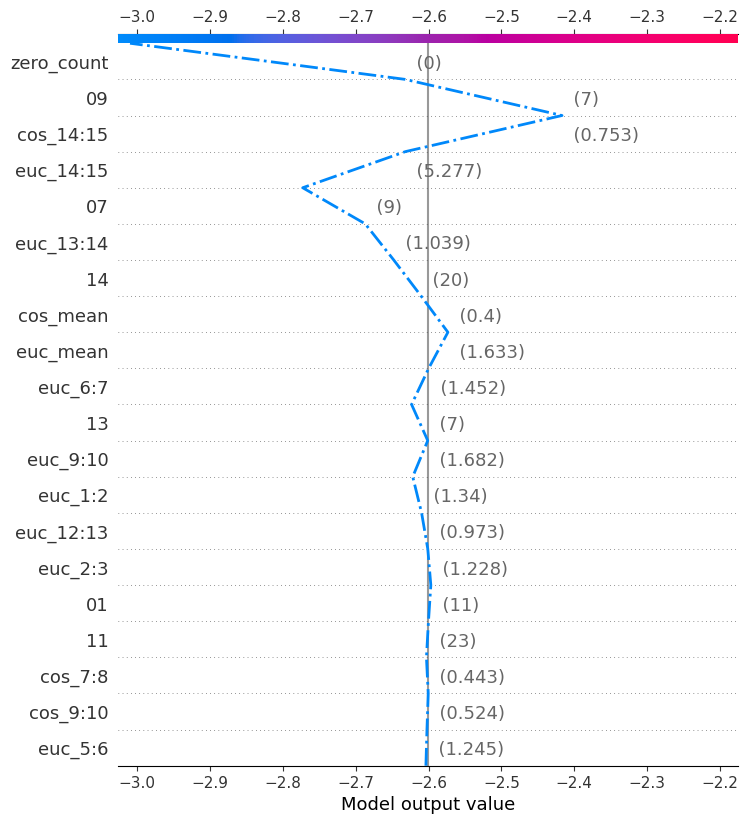

Class 1 SHAP Decision Plot


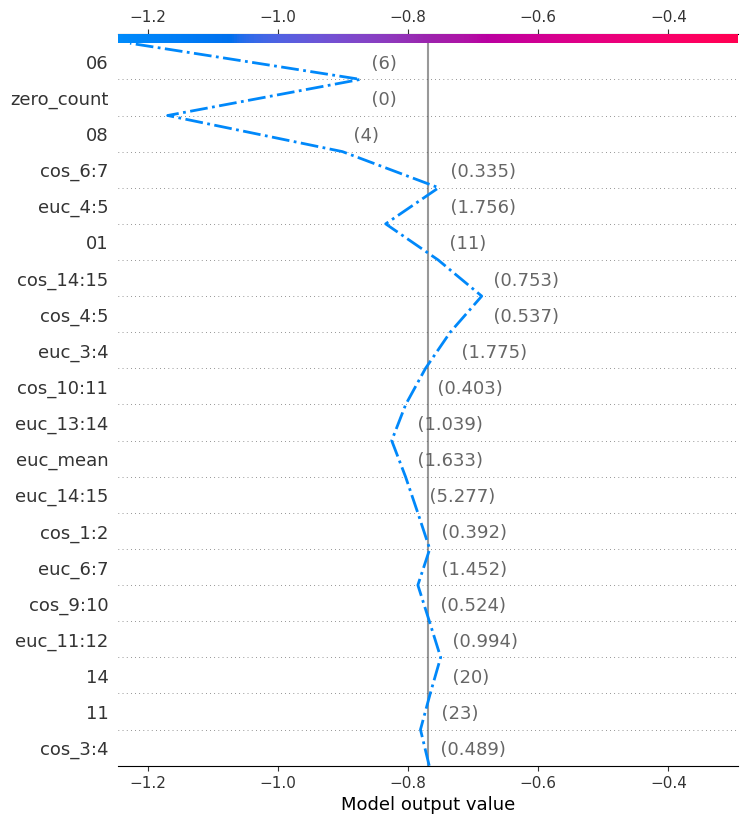

Class 2 SHAP Decision Plot


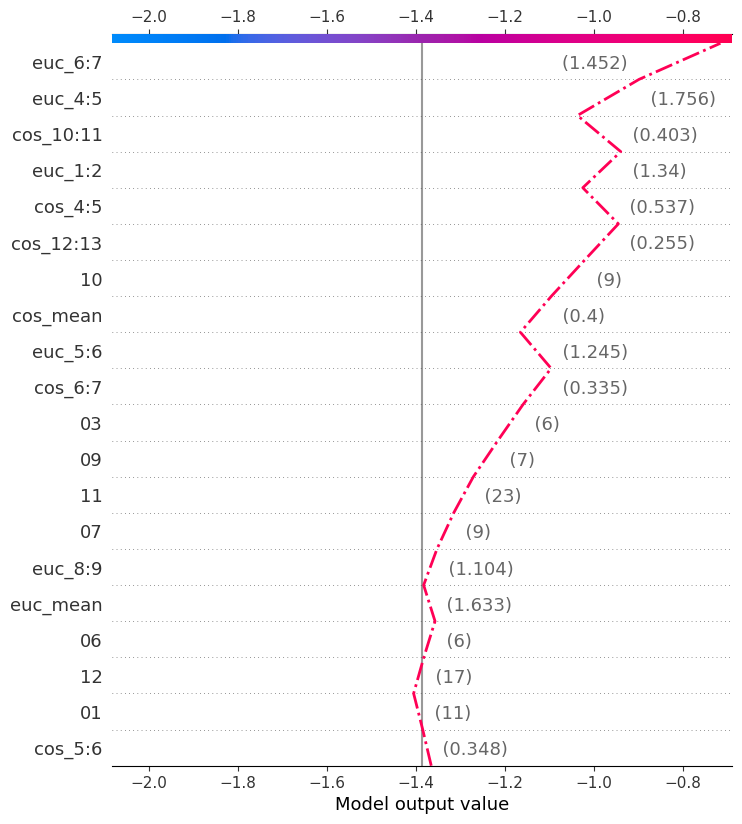

Class 3 SHAP Decision Plot


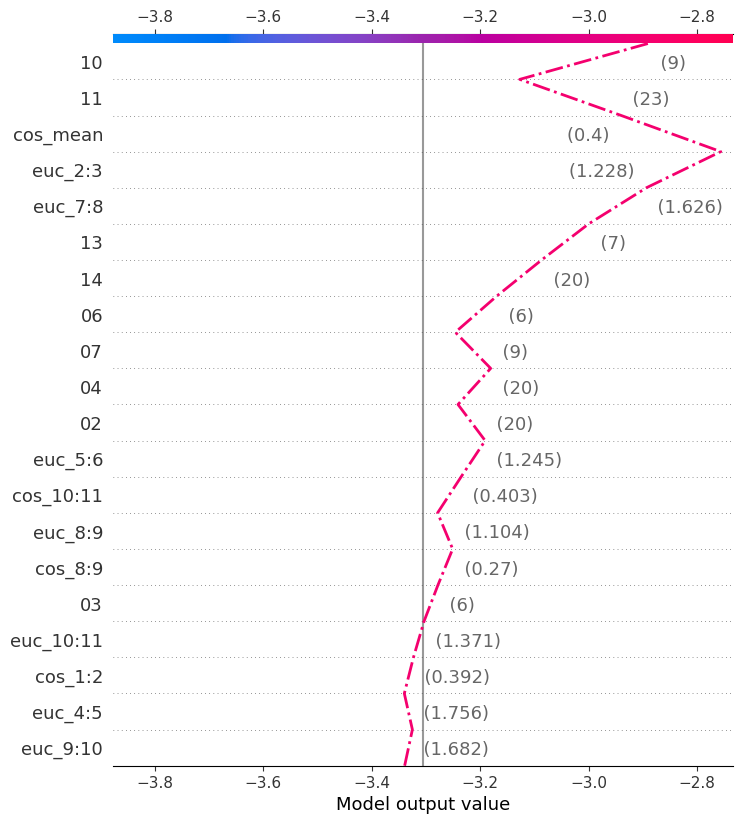

Class 4 SHAP Decision Plot


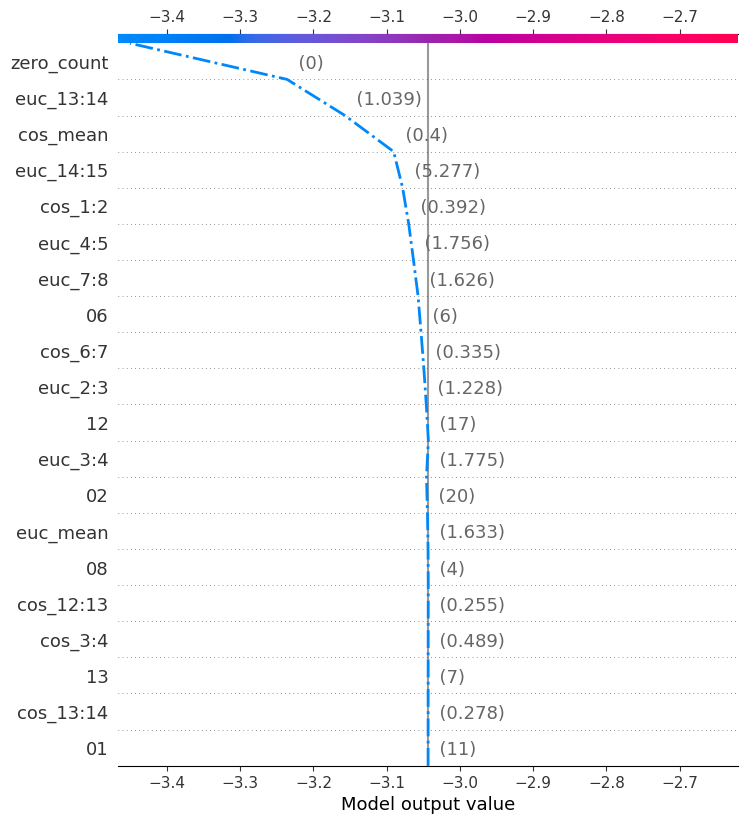

In [43]:
for class_idx in range(5):
    print(f"Class {class_idx} SHAP Decision Plot")
    
    # n番目のサンプルに対するSHAP値のフォースプロットを作成
    shap_values_for_decision_plot = shap.Explanation(
        values=shap_values[n, :, class_idx],
        base_values=explainer.expected_value[class_idx],
        data=X_test_shap.iloc[n, :],
        feature_names=X_test_shap.columns
    )
    
    # Decision Plotを表示
    shap.decision_plot(
        base_value=shap_values_for_decision_plot.base_values,
        shap_values=shap_values_for_decision_plot.values,
        features=X_test_shap.iloc[n, :].values,
        feature_names=X_test_shap.columns.tolist(),
        highlight=0  # n番目のサンプルをハイライト
    )

In [44]:
print(f"shape of shap_values: {shap_values[:, :, 0].shape}")
print(f"shape of X_test_shap: {X_test_shap.shape}")
print(f"columns: {X_test_shap.columns.tolist()}")

shape of shap_values: (75, 46)
shape of X_test_shap: (75, 46)
columns: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', 'zero_count', 'euc_1:2', 'euc_2:3', 'euc_3:4', 'euc_4:5', 'euc_5:6', 'euc_6:7', 'euc_7:8', 'euc_8:9', 'euc_9:10', 'euc_10:11', 'euc_11:12', 'euc_12:13', 'euc_13:14', 'euc_14:15', 'euc_mean', 'cos_1:2', 'cos_2:3', 'cos_3:4', 'cos_4:5', 'cos_5:6', 'cos_6:7', 'cos_7:8', 'cos_8:9', 'cos_9:10', 'cos_10:11', 'cos_11:12', 'cos_12:13', 'cos_13:14', 'cos_14:15', 'cos_mean']


In [57]:
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(X_test_shap)

2024-08-15 06:41:44,963 : python.util : INFO : 2 : Grade 0 SHAP Dependence Plot


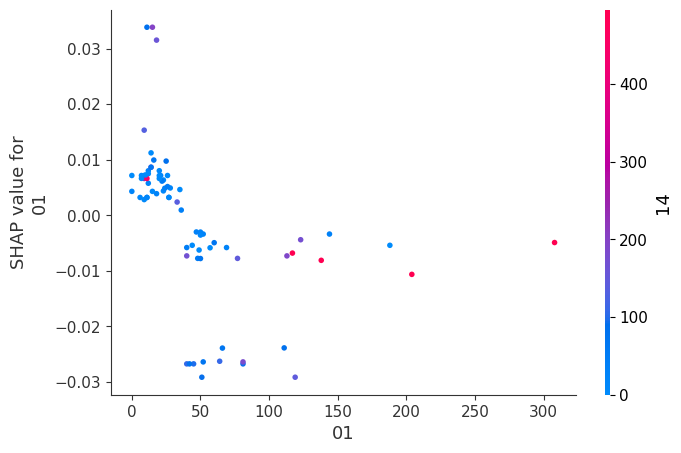

2024-08-15 06:41:45,243 : python.util : INFO : 2 : Grade 1 SHAP Dependence Plot


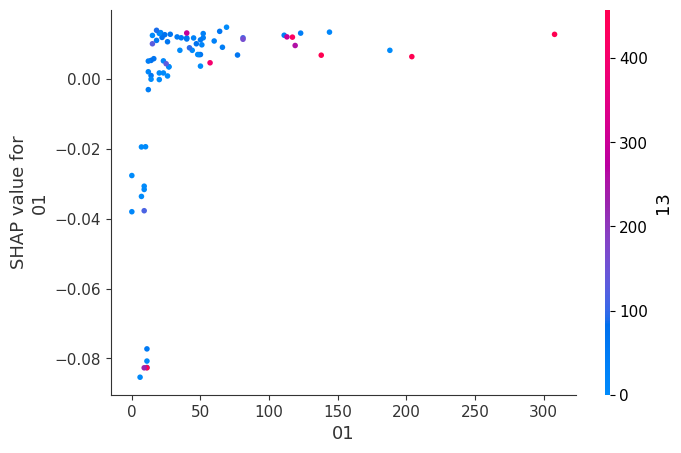

2024-08-15 06:41:45,487 : python.util : INFO : 2 : Grade 2 SHAP Dependence Plot


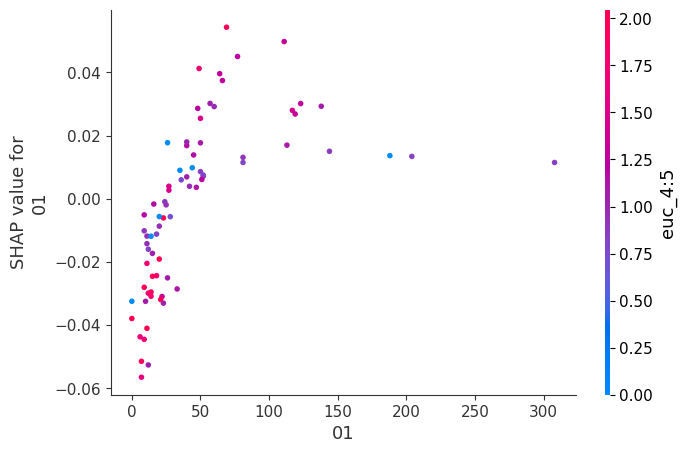

2024-08-15 06:41:45,748 : python.util : INFO : 2 : Grade 3 SHAP Dependence Plot


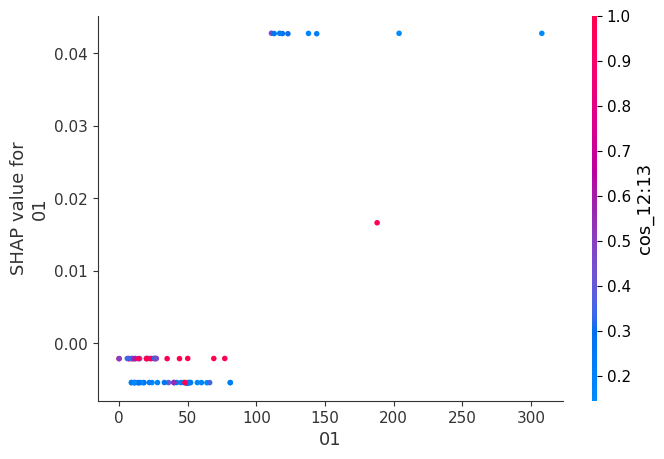

2024-08-15 06:41:45,996 : python.util : INFO : 2 : Grade 4 SHAP Dependence Plot


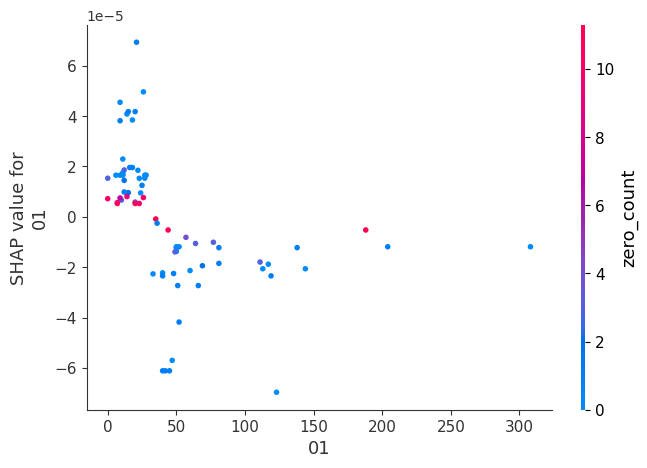

In [72]:
for i in range(5):
    logger.info(f"Grade {i} SHAP Dependence Plot")
    shap.dependence_plot(n, shap_values[:, :, i], X_test_shap.values, feature_names=X_test_shap.columns)

この結果から，成績0の判断根拠にはzero_countを重視していると考えられる．

In [82]:
shap.force_plot(explainer.expected_value[0], shap_values[:,:,0], X_test_shap, feature_names=X_test_shap.columns)


この結果から，クラス4の予測にはzero_countを中心にして見ていることがわかる．

In [83]:
shap.force_plot(explainer.expected_value[0], shap_values[:,:,4], X_test_shap, feature_names=X_test_shap.columns)
